In [2]:
# note: fdfdpy and nonlinear_avm must be in PATH
import sys
sys.path.append('..')
from fdfdpy.simulation import Simulation
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 1
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [4]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 5
spc = 1
l = 2

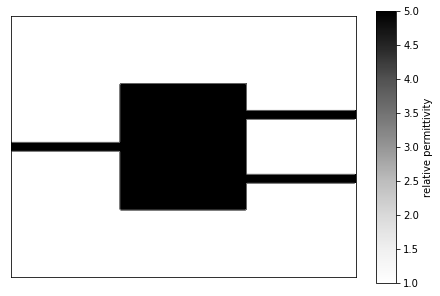

(205, 155)


In [7]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
shape = (Nx,Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)
simulation = Simulation(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()
print(eps_r.shape)

In [23]:
# simulation to solve
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 9.868405170262479 W/L0


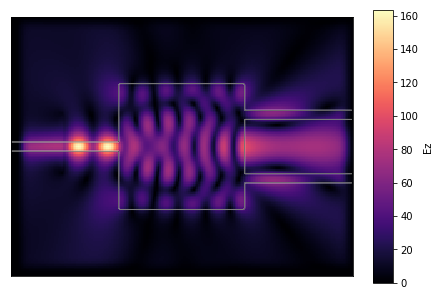

In [24]:
# plot linear field
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

Here is how nonlinearity works now:

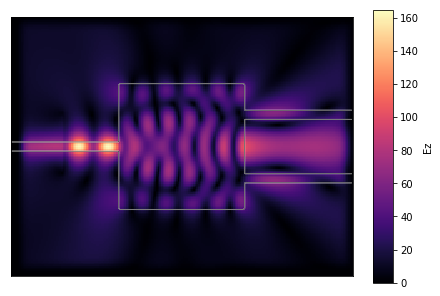

In [31]:
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
nl_region = np.array(eps_r > 1).astype(int)
nl_region[:nx-int(L/2/dl),:] = 0
nl_region[nx+int(L/2/dl):,:] = 0

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region)

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()

simulation.plt_abs()
plt.show()

And here's how optimization works. This is an optimization like before, no eps dependence anywhere, neither in J nor in the nonlinear function.

In [32]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define the derivatives
dJ = {}
dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_top
dJ['dE_nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot
dJ['total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin

# define the design and nonlinear regions
design_region = nl_region

In [35]:
# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJ=dJ, eps_max=eps_m, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

-14.303915414511895 -14.303928510344122 9.155417832905536e-07
-8.95311241621549 -8.953121869126335 1.0558239867598719e-06
-4.272612044831604 -4.272611076885369 2.2654671779410594e-07
-0.01622596046709157 -0.01622614945517853 1.1647266572660373e-05
-2.1364884062696783 -2.1364872918638866 5.216062901986667e-07
10.110142288674897 10.110146577062551 4.241668941372011e-07
-3.815702027946763 -3.8157056042109616 9.372493377008923e-07
-4.130284100722181 -4.130286833969876 6.617577939405461e-07
4.690944143438491 4.690945315815043 2.499233662875264e-07
-1.523532863148658 -1.5235338287311606 6.337785852715902e-07


100% (100 of 100) |######################| Elapsed Time: 0:03:51 ETA:  00:00:00

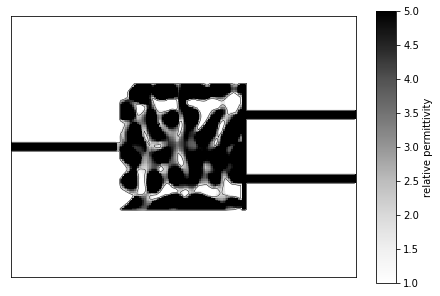

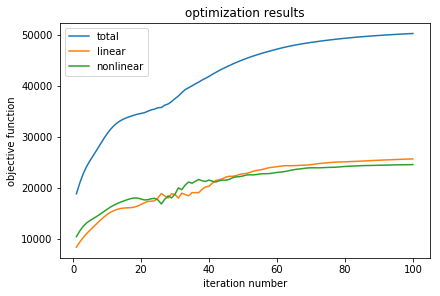

In [36]:
# run that optimization with the simulation and your objective function stuff
(new_eps_1) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

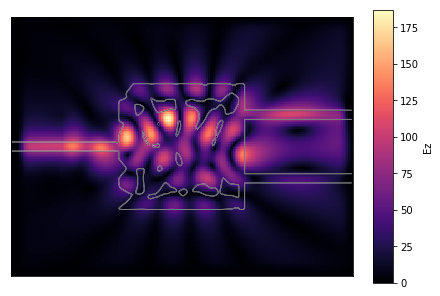

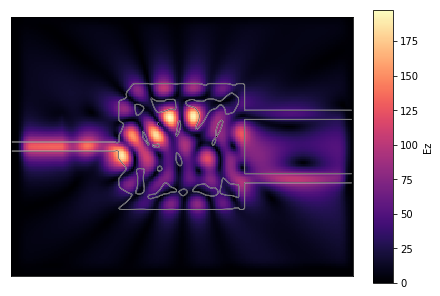

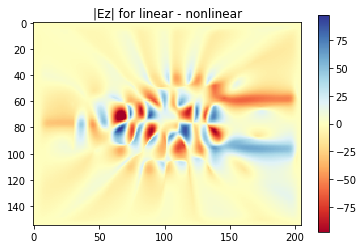

In [41]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs()
plt.show()

difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

And this is how we can scale the nonlinearity by the linear epsilon such that it is 0 when the eps_r is 1 and chi3 when eps_r is eps_max (and linearly scaled in between). Notice that there is a bit of difference from above, e.g. notice the scale.

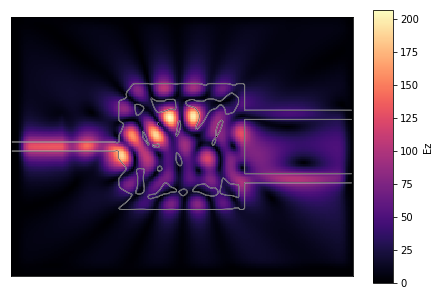

In [43]:
# compare the nonlinear and linear fields when we scale the nonlinearity
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region, eps_scale=True, eps_max=eps_m)

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs()
plt.show()

Running the optimization with the scaled nonlinearity results in a similar (but not identical) final structure.

In [49]:
# Re-initialize the simulation
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region, eps_scale=True, eps_max=eps_m)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJ=dJ, eps_max=eps_m, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

-13.241789935499064 -13.241804190329276 1.076503273474288e-06
-0.7811263865443359 -0.7811294926796108 3.976482331789818e-06
3.6880497395391973 3.688051911012735 5.887864023607645e-07
-2.62161680322351 -2.6216199876216706 1.2146695721512502e-06
1.6283901586588336 1.6283911645587068 6.177265735889838e-07
-0.43692299723580064 -0.43692418330465443 2.7145947027315725e-06
-3.311576035614528 -3.3115788392024115 8.466022985656962e-07
13.324094357400174 13.324101146281464 5.095191543919249e-07
0.13394974420214462 0.13394554116530344 3.137771457655299e-05
15.335691355486494 15.335703974415082 8.228470628268789e-07


100% (100 of 100) |######################| Elapsed Time: 0:03:47 ETA:  00:00:00

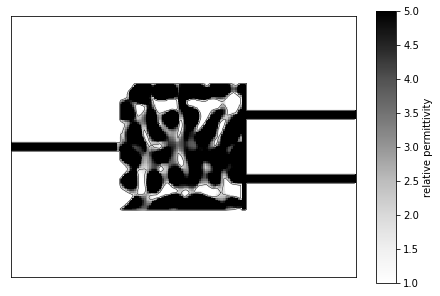

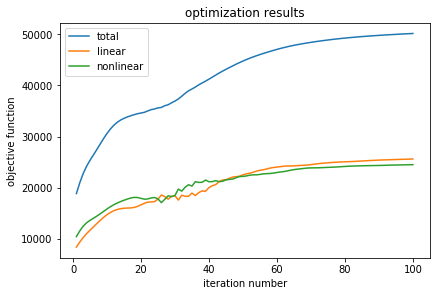

In [50]:
# run that optimization with the simulation and your objective function stuff
(new_eps_2) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

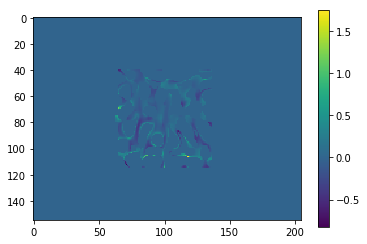

In [52]:
plt.imshow(np.real(new_eps_2 - new_eps_1).T)
plt.colorbar()
plt.show()

Finally, you can also add eps_r dependence in the objective function: 

In [59]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)/np.sum(eps_r)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)/np.sum(eps_r)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define the derivatives
dJ = {}
dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_top/np.sum(eps_r)
dJ['dE_nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot/np.sum(eps_r)
dJ['total'] = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin
dJ['deps_linear'] = lambda e, eps_r: -np.sum(np.square(np.abs(e))*J_top)/np.square(np.sum(eps_r))*np.ones(eps_r.shape)
dJ['deps_nonlinear'] = lambda e, eps_r: -np.sum(np.square(np.abs(e))*J_bot)/np.square(np.sum(eps_r))*np.ones(eps_r.shape)

In [70]:
# Re-initialize the simulation
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
simulation.nonlinearity = []
simulation.add_nl(chi3, design_region)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJ=dJ, eps_max=20, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, design_region)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.abs((avm_grads[i] - num_grads[i])/avm_grads[i]))

-0.00015979534404504108 -0.00015979551543088277 1.0725333877124843e-06
5.2907440103570036e-05 5.290746479813535e-05 4.667503335359534e-07
-5.866637652901077e-05 -5.8666422830810916e-05 7.892391330163086e-07
3.6886055026218905e-05 3.6886070309272156e-05 4.1433146593995304e-07
-6.286594068831895e-05 -6.286604264937878e-05 1.6218807627478928e-06
-7.806050928653223e-05 -7.806065349669211e-05 1.8474150528135163e-06
-4.1362028544962504e-05 -4.136212677918749e-05 2.3749856678520905e-06
-8.310786624298441e-05 -8.310795301946783e-05 1.044142839204455e-06
-6.773591042202676e-05 -6.773599153797605e-05 1.1975324282092382e-06
-9.595557139483859e-06 -9.595555738872719e-06 1.4596454586609928e-07


100% (100 of 100) |######################| Elapsed Time: 0:03:47 ETA:  00:00:00

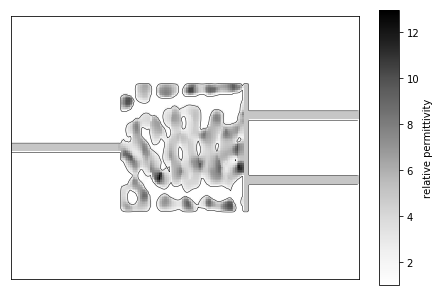

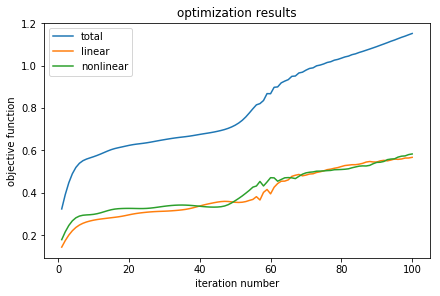

In [71]:
# run that optimization with the simulation and your objective function stuff
(new_eps_3) = opt_both.run(simulation, design_region)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()